In [1]:
#pip installs
!pip3 install -q ipython-autotime
!pip3 install h5py -q

In [2]:
%reload_ext autotime
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from itertools import islice

import gc
import h5py
from tqdm import tqdm
import librosa
import random

import warnings
warnings.filterwarnings("ignore", message="`torch.cuda.amp.autocast.*` is deprecated.*")

time: 3.75 s (started: 2024-11-24 05:09:49 +00:00)


In [3]:
class SplitDataset(Dataset):
    def __init__(self, h5_file, indices):
        self.h5_file = h5_file
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as hf:
            index = self.indices[idx]
            spectrogram = hf['spectrograms'][index] / 255.0  # Load one item and normalize
            label = hf['labels'][index]
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
            spectrogram = spectrogram.unsqueeze(0)
            label = torch.tensor(label, dtype=torch.long)

            # Call garbage collector periodically
            if idx % 1000 == 0:
                gc.collect()
            
            return spectrogram, label

time: 903 µs (started: 2024-11-24 05:09:52 +00:00)


In [4]:
def create_splits(h5_path, test_split=0.1, val_split=0.2, seed=42):
    """Create dataset splits without loading entire dataset"""
    # Get dataset size without loading data
    with h5py.File(h5_path, 'r') as f:
        total_size = len(f['spectrograms'])
        labels = f['labels'][:]

    labels = labels.argmax(axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Generate globally shuffled indices
    rng = np.random.RandomState(seed)
    all_indices = np.arange(total_size)
    rng.shuffle(all_indices)
    
    # Calculate split sizes
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - test_size - val_size
    
    # Create index lists for each split
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    
    # Create datasets using your SplitDataset class
    train_dataset = SplitDataset(h5_path, train_indices)
    val_dataset = SplitDataset(h5_path, val_indices)
    test_dataset = SplitDataset(h5_path, test_indices)
    
    return train_dataset, val_dataset, test_dataset, class_weights

time: 4.25 ms (started: 2024-11-24 05:09:52 +00:00)


In [5]:
def create_data_loaders(h5_path, batch_size=32, test_split=0.1, val_split=0.2,
                       seed=42, num_workers=4):
    """Create data loaders with memory-efficient splitting"""
    
    # Clear memory before creating splits
    gc.collect()
    torch.cuda.empty_cache()
    
    # Create datasets
    train_dataset, val_dataset, test_dataset, class_weights = create_splits(
        h5_path, test_split, val_split, seed
    )
    
    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle validation
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle test
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    return train_loader, val_loader, test_loader, class_weights

time: 6.56 ms (started: 2024-11-24 05:09:52 +00:00)


In [6]:
DATASET_SIZE = 105526
BATCH_SIZE = 32
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
NUM_WORKERS = 4
H5_PATH = '/kaggle/input/raga-ieee-preprocessing/processed_spectrograms.h5'

train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        h5_path=H5_PATH,
        batch_size=BATCH_SIZE,
        test_split=TEST_SPLIT,
        val_split=VAL_SPLIT,
        num_workers=NUM_WORKERS,
        seed=420
    )

print(f"\nDataset splits:")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Val size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Dataset splits:
Train size: 73869
Val size: 21105
Test size: 10552
time: 2.73 s (started: 2024-11-24 05:09:52 +00:00)


In [7]:
# from collections import defaultdict

# def label_distribution(dataloader):
#     label_counts = defaultdict(int)
    
#     for _, labels in dataloader:
#         # Convert one-hot encoded labels to class indices
#         label_indices = labels.argmax(dim=1)  # Get the index of the 1 in each one-hot label
        
#         for label in label_indices:
#             label_counts[label.item()] += 1
    
#     # Calculate the distribution as percentages
#     total_count = sum(label_counts.values())
#     label_distribution = {label: count / total_count * 100 for label, count in label_counts.items()}
    
#     print("Label distribution (in percentages):")
#     for label, percentage in label_distribution.items():
#         print(f"Class {label}: {percentage:.2f}% ({label_counts[label]} samples)")
    
#     return label_counts


# x = label_distribution(test_loader)
# plt.bar(x.keys(),x.values())

time: 544 µs (started: 2024-11-24 05:09:55 +00:00)


In [8]:
# def plot_mel_spectrogram(mel_spectrogram, sr=16000, hop_length=512, title="Mel Spectrogram"):
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mel_spectrogram, 
#                              sr=sr, 
#                              hop_length=hop_length, 
#                              x_axis='time', 
#                              y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

time: 10.6 ms (started: 2024-11-24 05:09:55 +00:00)


In [9]:
# # Get one random batch from the train_loader
# data_iter = iter(train_loader)
# spectrograms, labels = next(data_iter)

# # Select a random index within the batch
# random_idx = random.randint(0, spectrograms.size(0) - 1)

# # Get the spectrogram and label at that index
# spectrogram = spectrograms[random_idx].squeeze().numpy()
# label = labels[random_idx].argmax().item()  # Assuming one-hot encoded labels

# plot_mel_spectrogram(spectrogram, title=f"Mel Spectrogram for {label}")

time: 3.06 ms (started: 2024-11-24 05:09:55 +00:00)


In [10]:
# class CNNForSpectrograms(nn.Module):
#     def __init__(self):
#         super(CNNForSpectrograms, self).__init__()
        
#         # First block
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (256x256) -> (256x256)
#         self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
#         self.dropout1 = nn.Dropout(0.2)  # Dropout after first block
        
#         # Second block
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (128x128) -> (128x128)
#         self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
#         self.dropout2 = nn.Dropout(0.2)  # Dropout after second block
        
#         # Third block
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (64x64) -> (64x64)
#         self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
#         self.dropout3 = nn.Dropout(0.3)  # Dropout after third block
        
#         # Fourth block
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # (32x32) -> (32x32)
#         self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
#         self.dropout4 = nn.Dropout(0.3)  # Dropout after fourth block
        
#         # Final fully connected layer to reduce to a 16x16 feature space
#         self.fc = nn.Linear(256 * 16 * 16, 1024)  # Flattened 16x16x256 -> 1024
#         self.dropout_fc = nn.Dropout(0.4)  # Dropout before final output
        
#         # Output layer (for classification)
#         self.output = nn.Linear(1024, 10)  # For 10 thaat classes

#     def forward(self, x):
#         # Forward pass through convolutional blocks
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = self.dropout1(x)  # Apply dropout
        
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.dropout2(x)  # Apply dropout
        
#         x = F.relu(self.conv3(x))
#         x = self.pool3(x)
#         x = self.dropout3(x)  # Apply dropout
        
#         x = F.relu(self.conv4(x))
#         x = self.pool4(x)
#         x = self.dropout4(x)  # Apply dropout
        
#         # Flatten the output from convolutional layers
#         x = x.view(x.size(0), -1)  # Flatten: batch_size x (256*16*16)
        
#         # Fully connected layer with dropout
#         x = F.relu(self.fc(x))
#         x = self.dropout_fc(x)  # Apply dropout
        
#         # Output layer for classification
#         x = self.output(x)
        
#         return x

time: 3.55 ms (started: 2024-11-24 05:09:55 +00:00)


In [11]:
class CNN_with_BottleNeck(nn.Module):
    def __init__(self):
        super(CNN_with_BottleNeck, self).__init__()
        
        # Feature extraction blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.05)  # Dropout after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=0.1)  # Dropout after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(p=0.1)  # Dropout after conv3
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(p=0.15)  # Dropout after conv4
        
        # Additional convolutional block for better feature extraction
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # (16x16) -> (8x8)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout2d(p=0.2)  # Dropout after conv5
        
        # Bottleneck: Progressive channel reduction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)
        )
        
        # Global average pooling for spatial reduction
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification head
        self.fc = nn.Linear(1 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)  # Apply dropout after conv1
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)  # Apply dropout after conv2
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)  # Apply dropout after conv3
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)  # Apply dropout after conv4
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)  # Apply dropout after conv5
        
        x = self.bottleneck(x)  # Shape: (batch_size, 1, 8, 8)
        x = self.global_pool(x)  # Shape: (batch_size, 1, 4, 4)
        
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 16)
        x = self.fc(x)  # Shape: (batch_size, 10)
        
        return x


time: 3.17 ms (started: 2024-11-24 05:09:55 +00:00)


In [12]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    
    # Create progress bar for validation
    val_pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for spectrograms, labels in val_pbar:
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({'loss': loss.item()})
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    
    return val_loss, val_accuracy

time: 5.79 ms (started: 2024-11-24 05:09:55 +00:00)


In [13]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []
    
    # Create progress bar for testing
    test_pbar = tqdm(test_loader, desc='Testing')
    
    with torch.no_grad():
        for spectrograms, labels in test_pbar:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
            
            test_predictions.extend(predicted.cpu().numpy())  # Convert to numpy array of class indices
            test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Convert one-hot to class indices
    
    # Convert to numpy arrays for consistency
    test_predictions = np.array(test_predictions)
    test_labels = np.array(test_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
    
    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

time: 6.52 ms (started: 2024-11-24 05:09:55 +00:00)


In [14]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

time: 5.99 ms (started: 2024-11-24 05:09:55 +00:00)


In [15]:
def train_model(model, train_loader, val_loader, num_epochs, class_weights, device='cuda'):
    # Initialize model, loss, and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for spectrograms, labels in train_pbar:
            # Move data to device
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_predictions)
        
        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),  # Save LR scheduler state
                'train_losses': train_losses,  # Training losses for all epochs
                'val_losses': val_losses,      # Validation losses for all epochs
                'train_accuracies': train_accuracies,  # Training accuracies for all epochs
                'val_accuracies': val_accuracies,      # Validation accuracies for all epochs
                'val_loss': val_loss,  # Best validation loss
            }, 'best_model_4x4_dropout_2.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= 5:  # Early stopping patience
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        
        # Print epoch metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        torch.cuda.empty_cache()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

time: 2.82 ms (started: 2024-11-24 05:09:55 +00:00)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = RagaFeatureExtractorCNN(input_channels=1, num_classes=10).to(device)
model = CNN_with_BottleNeck().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

print(model)

Using 2 GPUs!
DataParallel(
  (module): CNN_with_BottleNeck(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.05, inplace=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.1, inplace=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout2d(p=0.1, inplace=False)
    (conv4): Conv2d

In [17]:
history = train_model(model, 
                      train_loader,
                      val_loader,
                      num_epochs=25,
                      class_weights=class_weights.to(device),
                      device=device)

Validation: 100%|██████████| 660/660 [01:38<00:00,  6.68it/s, loss=1.85]



Epoch 1/25:
Train Loss: 2.0897, Train Accuracy: 0.2178
Val Loss: 1.6985, Val Accuracy: 0.3926


Validation: 100%|██████████| 660/660 [01:48<00:00,  6.11it/s, loss=1.28] 



Epoch 2/25:
Train Loss: 1.4109, Train Accuracy: 0.5020
Val Loss: 1.3148, Val Accuracy: 0.5325


Validation: 100%|██████████| 660/660 [01:40<00:00,  6.57it/s, loss=0.822]



Epoch 3/25:
Train Loss: 1.0453, Train Accuracy: 0.6365
Val Loss: 0.8440, Val Accuracy: 0.7128


Validation: 100%|██████████| 660/660 [01:48<00:00,  6.08it/s, loss=0.571]



Epoch 4/25:
Train Loss: 0.8544, Train Accuracy: 0.7033
Val Loss: 0.6887, Val Accuracy: 0.7602


Validation: 100%|██████████| 660/660 [01:46<00:00,  6.17it/s, loss=0.605]



Epoch 5/25:
Train Loss: 0.7375, Train Accuracy: 0.7438
Val Loss: 0.5979, Val Accuracy: 0.8036


Validation: 100%|██████████| 660/660 [01:41<00:00,  6.49it/s, loss=0.449]



Epoch 6/25:
Train Loss: 0.6509, Train Accuracy: 0.7734
Val Loss: 0.5410, Val Accuracy: 0.8170


Validation: 100%|██████████| 660/660 [01:45<00:00,  6.25it/s, loss=0.337]



Epoch 7/25:
Train Loss: 0.5866, Train Accuracy: 0.7938
Val Loss: 0.5017, Val Accuracy: 0.8346


Validation: 100%|██████████| 660/660 [01:43<00:00,  6.38it/s, loss=0.438]



Epoch 8/25:
Train Loss: 0.5329, Train Accuracy: 0.8146
Val Loss: 0.4687, Val Accuracy: 0.8480


Validation: 100%|██████████| 660/660 [01:41<00:00,  6.48it/s, loss=0.228] 



Epoch 9/25:
Train Loss: 0.4962, Train Accuracy: 0.8255
Val Loss: 0.4302, Val Accuracy: 0.8593


Validation: 100%|██████████| 660/660 [01:39<00:00,  6.63it/s, loss=0.353] 



Epoch 10/25:
Train Loss: 0.4620, Train Accuracy: 0.8370
Val Loss: 0.4117, Val Accuracy: 0.8663


Validation: 100%|██████████| 660/660 [01:44<00:00,  6.30it/s, loss=0.266] 



Epoch 11/25:
Train Loss: 0.4335, Train Accuracy: 0.8487
Val Loss: 0.4155, Val Accuracy: 0.8665


Validation: 100%|██████████| 660/660 [01:41<00:00,  6.50it/s, loss=0.27]  



Epoch 12/25:
Train Loss: 0.4015, Train Accuracy: 0.8574
Val Loss: 0.3529, Val Accuracy: 0.8870


Validation: 100%|██████████| 660/660 [01:44<00:00,  6.29it/s, loss=0.22]  



Epoch 13/25:
Train Loss: 0.3869, Train Accuracy: 0.8643
Val Loss: 0.3520, Val Accuracy: 0.8887


Validation: 100%|██████████| 660/660 [01:42<00:00,  6.44it/s, loss=0.186] 



Epoch 14/25:
Train Loss: 0.3665, Train Accuracy: 0.8720
Val Loss: 0.3622, Val Accuracy: 0.8884


Validation: 100%|██████████| 660/660 [01:40<00:00,  6.57it/s, loss=0.546] 



Epoch 15/25:
Train Loss: 0.3517, Train Accuracy: 0.8753
Val Loss: 0.3384, Val Accuracy: 0.8950


Validation: 100%|██████████| 660/660 [01:42<00:00,  6.41it/s, loss=0.339] 



Epoch 16/25:
Train Loss: 0.3334, Train Accuracy: 0.8848
Val Loss: 0.3301, Val Accuracy: 0.8965


Validation: 100%|██████████| 660/660 [01:42<00:00,  6.46it/s, loss=0.206] 



Epoch 17/25:
Train Loss: 0.3230, Train Accuracy: 0.8868
Val Loss: 0.3560, Val Accuracy: 0.8898


Validation: 100%|██████████| 660/660 [01:44<00:00,  6.30it/s, loss=0.124] 



Epoch 18/25:
Train Loss: 0.3036, Train Accuracy: 0.8915
Val Loss: 0.3089, Val Accuracy: 0.9052


Validation: 100%|██████████| 660/660 [01:42<00:00,  6.44it/s, loss=0.154] 



Epoch 19/25:
Train Loss: 0.2999, Train Accuracy: 0.8938
Val Loss: 0.2920, Val Accuracy: 0.9087


Validation: 100%|██████████| 660/660 [01:48<00:00,  6.11it/s, loss=0.0756]



Epoch 20/25:
Train Loss: 0.2892, Train Accuracy: 0.8970
Val Loss: 0.3006, Val Accuracy: 0.9079


Validation: 100%|██████████| 660/660 [01:43<00:00,  6.39it/s, loss=0.206] 



Epoch 21/25:
Train Loss: 0.2804, Train Accuracy: 0.9003
Val Loss: 0.3064, Val Accuracy: 0.9044


Validation: 100%|██████████| 660/660 [01:43<00:00,  6.39it/s, loss=0.116] 



Epoch 22/25:
Train Loss: 0.2749, Train Accuracy: 0.9021
Val Loss: 0.2944, Val Accuracy: 0.9088


Validation: 100%|██████████| 660/660 [01:39<00:00,  6.66it/s, loss=0.322] 



Epoch 23/25:
Train Loss: 0.2658, Train Accuracy: 0.9066
Val Loss: 0.2916, Val Accuracy: 0.9110


Validation: 100%|██████████| 660/660 [01:45<00:00,  6.28it/s, loss=0.0883]



Epoch 24/25:
Train Loss: 0.2530, Train Accuracy: 0.9094
Val Loss: 0.2868, Val Accuracy: 0.9089


Validation: 100%|██████████| 660/660 [01:43<00:00,  6.36it/s, loss=0.0847]


Epoch 25/25:
Train Loss: 0.2523, Train Accuracy: 0.9107
Val Loss: 0.2876, Val Accuracy: 0.9140
time: 3h 15min 20s (started: 2024-11-24 05:09:56 +00:00)


Best Validation Loss: 0.2867889052764936


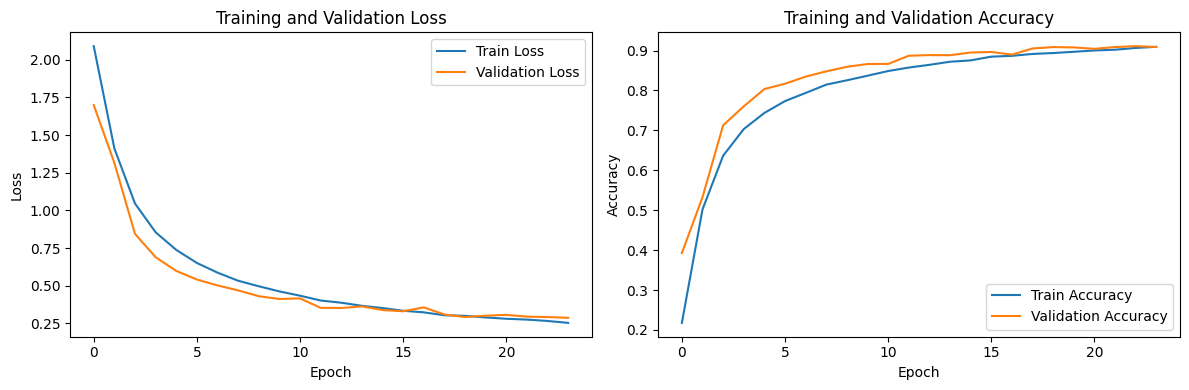

time: 561 ms (started: 2024-11-24 08:32:10 +00:00)


In [22]:
checkpoint = torch.load('/kaggle/working/best_model_4x4_dropout_2.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
best_val_loss = checkpoint['val_loss']

# val_losses = checkpoint['val_loss']
print(f"Best Validation Loss: {best_val_loss}")

model.eval()
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
test_metrics = test_model(model, test_loader, device)

Testing: 100%|██████████| 330/330 [00:52<00:00,  6.30it/s]


Test Results:
Accuracy: 0.9082
Precision: 0.9097
Recall: 0.9082
F1 Score: 0.9084
time: 52.4 s (started: 2024-11-24 08:32:16 +00:00)
